# Ironhack Delivery project

## Ejercicio #3: Experimento

### ¿Qué tipo de prueba requeriría esto?
Un experimento controlado A/B. Donde habría dos grupos:
- Grupo de control a 1,9€
- Grupo de tratamiento a 2,1€

### ¿Probarías esto solo en nuevos usuarios o en todos los usuarios activos? ¿Por qué?
Todos los usuarios ya que aseguras que la muestra sea de usuarios recurrentes y de nuevos.

### ¿Qué suposiciones harías y cómo probarías si estas suposiciones son correctas?
Que ambos grupos (de control y tratamiento) sean iguales (en cuanto a características).
Que la sensibilidad al precio no varía por otros factores que no tienen que ver con la prueba.

Pruebas: Hacer un análisis de equilibro para asegurarnos que las muestras son homogéneas.

### ¿Qué enfoque usarías para determinar la duración del experimento?
El objetivo es tener un nivel de significancia de aprox 95% y un poder estadístico de alrededor de 80%, por lo que hay que usar una fórmula para calcular el tamaño de la muestra y determinar la duración necesaria para alcanzar estos niveles. Hay que tener en cuenta la tasa de conversión y el efecto esperado por esta subida de tarifa.

### ¿Qué KPIs/métricas elegirías para evaluar el éxito de la prueba?
Principales KPIs/métricas para evaluar el éxito de la prueba:
- Tasa de completación de pedidos, 
- Valor promedio de cada pedido, 
- La retención de usuarios y la satisfacción de los clientes.
- Otros: Abandono de la compra a medias, Cancelación de pedidos.

### ¿Qué pasos tomarías para analizar los resultados de la prueba?
Como método, primero análisis de cuán diferentes sean los grupos. Pruebas estadísiticas (como el t-test para comparar los KPis). Y Regresiones para ajustar variables de control y verificar la consistencia de los resultados.

Para ver los resultados seguramente diagramas de barras, de puntos o incluso de cajas para ver las diferencias entre los dos grupos.

### ¿Cuáles serían tus recomendaciones según los resultados de la prueba?
Si el grupo nuevo mejora, o se queda igual, haría el cambio a la nueva tarifa para todos.
Si el grupo nuevo empeora, mantendría los precios antiguos.

## Experimento A/B y Optimización

In [60]:
# Library
import random
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind, norm, ks_2samp
from statsmodels.stats.power import TTestIndPower

In [61]:
headers = [
    'order_id', 'activation_time_local', 'country_code', 'store_address', 'final_status', 'payment_status', 'products', 'products_total', 'purchase_total_price'
]

dataold = pd.read_csv('./project_dataset/python_raw_data/fake_orders_test.csv', header=None, names=headers)
dataold.to_csv('./project_dataset/python_raw_data/fake_orders_test_headers.csv', index=False)

In [62]:
data = pd.read_csv('./project_dataset/python_raw_data/fake_orders_test_headers.csv')
data.head()

,order_id,activation_time_local,country_code,store_address,final_status,payment_status,products,products_total,purchase_total_price
0,33557880,2019-03-10 23:59:59.000000,AR,14200,DeliveredStatus,PAID,1,4.54,8.64
1,33512615,2019-03-10 23:58:32.000000,TR,28725,DeliveredStatus,PAID,1,3.76,3.76
2,33512451,2019-03-10 23:57:56.000000,TR,28725,DeliveredStatus,PAID,1,2.86,2.86
3,33530892,2019-03-10 23:57:33.000000,ES,19777,CanceledStatus,PAID,1,12.95,0.00
4,33557765,2019-03-10 23:57:21.000000,AR,34565,DeliveredStatus,PAID,2,2.86,6.48


In [63]:
# Generate a list of 100000 random fake users between 1 and 100000
#population = 1000000

# Create the synthetic data for the ab testing example
#population_data = [random.randint(1, 100) for _ in range(population)]
population_data = data['products_total']

# Convert it into 
df = pd.DataFrame({'products_total':population_data})
df.head()

,products_total
0,4.54
1,3.76
2,2.86
3,12.95
4,2.86


### 1. Calcular el Efecto Mínimo Detectable (EMD) para Definir el Tamaño de la Muestra

In [64]:
# Initialize variables
contador = 0  # This will track the fraction of the dataset allocated to the test group
data = {}  # To store results

# Loop to calculate MDE for splits ranging from 5% to 50% of the dataset
while contador <= 0.45:
    contador += 0.05  # Increment the fraction for each iteration
    mde_list = []  # To store MDE values for each iteration
    avg_list = []  # To store average values for the control group
    
    # Perform 30 simulations for each split to average the MDE
    for i in range(1, 31):
        # Randomly split the dataset into test and control groups based on the current fraction
        test_df, control_df = train_test_split(df, test_size=contador)
        
        # Define the parameters for the MDE calculation
        alpha = 0.05  # Significance level
        beta = 0.8    # Desired statistical power
        
        # Calculate standard deviations for both groups
        std_dev_test = np.std(test_df['products_total'])
        std_dev_control = np.std(control_df['products_total'])
        
        # Calculate sample sizes
        sample_size_control = len(control_df)
        sample_size_test = len(test_df)
        
        # Calculate critical values for the two-tailed test
        z_alpha = norm.ppf(1 - alpha/2)
        z_beta = norm.ppf(beta)
        
        # Calculate pooled standard deviation
        pooled_std_dev = np.sqrt(((sample_size_control - 1) * std_dev_control**2 + 
                                  (sample_size_test - 1) * std_dev_test**2) / 
                                 (sample_size_control + sample_size_test - 2))
        
        # Calculate the MDE
        mde = (z_alpha + z_beta) * pooled_std_dev * np.sqrt(2 / sample_size_control)
        
        # Append the MDE and average control group price to their respective lists
        mde_list.append(mde)
        avg = np.mean(control_df['products_total'])
        avg_list.append(avg)
    
    # Calculate and store the average MDE, average price, and MDE percentage for the current split
    data[(round(contador, 2))] = {'mde': round(np.mean(mde_list), 4),
                                  'avg': round(np.mean(avg_list), 4),
                                  'mde_%': round(np.mean(mde_list) / np.mean(avg_list) * 100, 2)}

In [65]:
# Computed value for the sample selected
data

{0.05: {'mde': 0.6688, 'avg': 9.8003, 'mde_%': 6.82},
 0.1: {'mde': 0.4729, 'avg': 9.7847, 'mde_%': 4.83},
 0.15: {'mde': 0.3861, 'avg': 9.8672, 'mde_%': 3.91},
 0.2: {'mde': 0.3344, 'avg': 9.8468, 'mde_%': 3.4},
 0.25: {'mde': 0.2991, 'avg': 9.8363, 'mde_%': 3.04},
 0.3: {'mde': 0.273, 'avg': 9.8205, 'mde_%': 2.78},
 0.35: {'mde': 0.2528, 'avg': 9.8482, 'mde_%': 2.57},
 0.4: {'mde': 0.2365, 'avg': 9.835, 'mde_%': 2.4},
 0.45: {'mde': 0.2229, 'avg': 9.8332, 'mde_%': 2.27},
 0.5: {'mde': 0.2115, 'avg': 9.8455, 'mde_%': 2.15}}

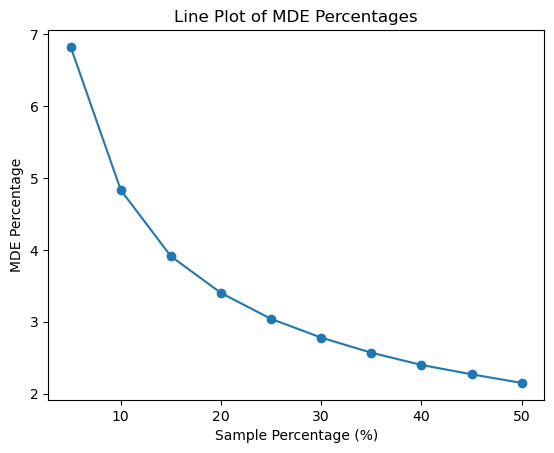

In [66]:
# Prepare data for plotting
percentage_split = [float(key)*100 for key in data.keys()]  # Convert keys to float and multiply by 100 to get percentages
mde_percentage_list_hist = [value['mde_%'] for value in data.values()]  # Extract MDE percentages

# Plotting
plt.plot(percentage_split, mde_percentage_list_hist, marker='o')  # 'o' adds markers to the line plot
plt.title('Line Plot of MDE Percentages')
plt.xlabel('Sample Percentage (%)')  # Updated to display counter percentage of the sample
plt.ylabel('MDE Percentage')

# Show the plot
plt.show()

### 2. División Aleatoria para Pruebas A/B

In [67]:
# We run the split with 30% in test, as per the MDE curve we think it is the most optimal business<>statistical
test_df, control_df = train_test_split(df, test_size=0.3)

In [68]:
test_df

,products_total
28777,11.93
11200,9.57
18003,8.85
2322,6.32
57321,3.85
...,...
44424,15.00
17910,6.00
8568,6.45
27730,0.66


In [69]:
control_df

,products_total
44007,10.67
38048,5.90
1506,4.10
44943,22.89
2327,6.50
...,...
42463,4.86
50920,11.44
42517,2.19
18497,8.46


### 3. Realizar una Prueba KS y una Prueba de Equivalencia

In [70]:
# Selecting the data from each DataFrame
# data1 = control_df['price']  # We select the column price from our df
# data2 = test_df['price']  # We select the column price from our df
data1 = control_df
data2 = test_df

# Perform the KS test
statistic, p_value = ks_2samp(data1, data2)

print(f"KS statistic: {statistic}")
print(f"P-value: {p_value}")

KS statistic: [0.00776569]
P-value: [0.42659964]


In [73]:
# Define the equivalence limits
low, upp = -0.2, 0.2 

# Unpacking the results
p_value_global, result_lower, result_upper = sm.stats.ttost_ind(data1, data2, low, upp)

# Print the results
print(f"Global p-value of TOST: {p_value_global}")
print(f"Inferiority test (difference > lower margin): Statistic = {result_lower[0]}, p-value = {result_lower[1]}")
print(f"Superiority test (difference < upper margin): Statistic = {result_upper[0]}, p-value = {result_upper[1]}")

# Interpretation based on p-values
if p_value_global < 0.05:
    print("There is enough statistical evidence to claim that the two groups are equivalent within the specified equivalence margin.")
else:
    print("There is not enough evidence to claim that the two groups will behave equally with a raise in the delivery fee.")

Global p-value of TOST: [0.09469012]
Inferiority test (difference > lower margin): Statistic = [3.54368454], p-value = [0.00019744]
Superiority test (difference < upper margin): Statistic = [-1.31242953], p-value = [0.09469012]
There is not enough evidence to claim that the two groups will behave equally with a raise in the delivery fee.


In [74]:
# Perform the t-test
t_stat, p_value = ttest_ind(data1, data2)

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

T-statistic: [1.11562751]
P-value: [0.26458605]
There is no significant difference between the two groups.
